In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import localtime, strftime
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import torch.optim as optim
import sklearn.preprocessing as preprocess
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import covariance as cov
import wfdb
import pandas as pd
from pdb import set_trace as bp
%matplotlib inline

In [2]:
from skorch import NeuralNetClassifier
# from skorch.classifier import NeuralNetBinaryClassifier, CVSplit
from skorch.callbacks import EpochScoring

In [3]:
data_dir = '/media/l7/data_storage1/datasets/afib_dataset/training2017/'

In [4]:

def get_fft(data, absolute_value=True):
    """
    Compute the fft for a specific input dataset.
    :param data:
    :param absolute_value:
    :return:
    """
    fft_data = np.fft.fft(data, axis=0) * 1/len(data)
    if not absolute_value:
        return fft_data
    else:
        abs_fft_data = abs(fft_data[:int(len(fft_data) / 2)])
        return abs_fft_data


def label_mapping(label):
    if label == 'N':
        return 0
    elif label =='A':
        return 1
    elif label =='O': 
        return 2
    else: 
        return 3
    
class GeneralDataset(torch_data.Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self,):
        return len(self.data)
    
    def __getitem__(self,index):
        sample = {'signal': torch.tensor(self.data[index]).float(),
                 'label': torch.tensor(self.labels[index]).long()}
        return sample

In [5]:
data_np = np.load(data_dir + 'data_np.npy')
fft_data_np = np.load(data_dir + 'fft_data_np.npy')
labels_np = np.load(data_dir + 'labels.npy')
data_np

array([[-0.127, -0.162, -0.197, ...,  0.   ,  0.   ,  0.   ],
       [ 0.128,  0.157,  0.189, ...,  0.   ,  0.   ,  0.   ],
       [ 0.056,  0.073,  0.085, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [-0.202, -0.235, -0.272, ...,  0.   ,  0.   ,  0.   ],
       [-0.227, -0.297, -0.374, ...,  0.   ,  0.   ,  0.   ],
       [-0.237, -0.286, -0.338, ...,  0.   ,  0.   ,  0.   ]])

In [6]:
validation_data_np = np.load(data_dir + 'validation_data_np.npy')
validation_fft_data_np = np.load(data_dir + 'validation_fft_data_np.npy')
validation_labels_np = np.load(data_dir + 'validation_labels.npy')
validation_data_np

array([[-0.127, -0.162, -0.197, ...,  0.   ,  0.   ,  0.   ],
       [ 0.128,  0.157,  0.189, ...,  0.   ,  0.   ,  0.   ],
       [ 0.056,  0.073,  0.085, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.565,  0.676,  0.783, ...,  0.   ,  0.   ,  0.   ],
       [-0.039, -0.06 , -0.077, ...,  0.   ,  0.   ,  0.   ],
       [-0.268, -0.325, -0.383, ...,  0.   ,  0.   ,  0.   ]])

In [7]:
sample_size = 9000

In [8]:
standard_scaler = preprocess.StandardScaler()
standard_scaler.fit(data_np[:,:sample_size])
processed_data = standard_scaler.transform(data_np[:,:sample_size])

In [9]:
standard_scaler = preprocess.StandardScaler()
standard_scaler.fit(validation_data_np[:,:sample_size])
validation_processed_data = standard_scaler.transform(validation_data_np[:,:sample_size])

In [10]:
def add_noise_to_dataset(data, numpy_data=False, noise_distribution=None, std=1.0):
    """
    This function adds noise to data array. Noise is added for some specific distribution, with a set
    standard deviation.
    :param data: numpy array
    :param numpy_data: bool, describing whether or not the data is a numpy array (otherwise it will be torch tensor)
    :param noise_distribution:
    :param std:
    :return: numpy array with added noise
    """
    numpy_tensor = False
    pytorch_tensor = False
    if not numpy_data:
        if 'numpy' in str(type(data)):
            numpy_tensor = True
            data = torch.tensor(data).float()
        else:
            pytorch_tensor = True

    if not noise_distribution:
        if numpy_data:
            noise_distribution = np.random.randn(data.shape[0], data.shape[1])
            data = data + noise_distribution
        else:
            noise_distribution = np.random.randn(data.shape[0], data.shape[1], data.shape[2])
            data = data + torch.tensor(noise_distribution).float().to(data.device)

    else:
        if numpy_data:
            data = data + noise_distribution(scale=std,
                                             size=[data.shape[0], data.shape[1]])
        else:
            data = data + torch.tensor(
                noise_distribution(scale=std, size=[data.shape[0], data.shape[1], data.shape[2]])).float().to(data.device)
    if pytorch_tensor:
        return data
    elif numpy_data:
        return data
    else:
        return data.numpy()

In [11]:
def double_class_rows(dataset, labels, class_number=1, random_state=1,
                     add_noise=False, noise_distribution=None, std=1.0):
    """
    This function helps balance by adding (or cloning) observations of a specific type.
    :param dataset:
    :param labels:
    :param class_number:
    :param random_state:
    :return:
    """
#     bp()
    sample_rows = np.where(labels == class_number)
    if add_noise:
        dataset_new = add_noise_to_dataset(dataset[sample_rows],
                                numpy_data=True, 
                                noise_distribution=noise_distribution, 
                                std=std)
    else:
        dataset_new = dataset[sample_rows]
    dataset = np.concatenate((dataset, dataset_new))
    labels = np.concatenate((labels, labels[sample_rows]))
    dataset, x_test, labels, y_test = train_test_split(dataset,
                                                      labels,
                                                      test_size=0,
                                                      random_state=random_state)
    print(dataset.shape)
    return dataset, labels
    

In [12]:
train_data = processed_data

In [13]:
test_data = validation_processed_data

In [14]:
train_data, labels_train = double_class_rows(train_data, labels_np, class_number=1, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)


(9266, 9000)


In [15]:
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=3, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.3)

(9550, 9000)


In [16]:
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=3, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.5)

(10118, 9000)


In [17]:
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=1, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)

(11594, 9000)


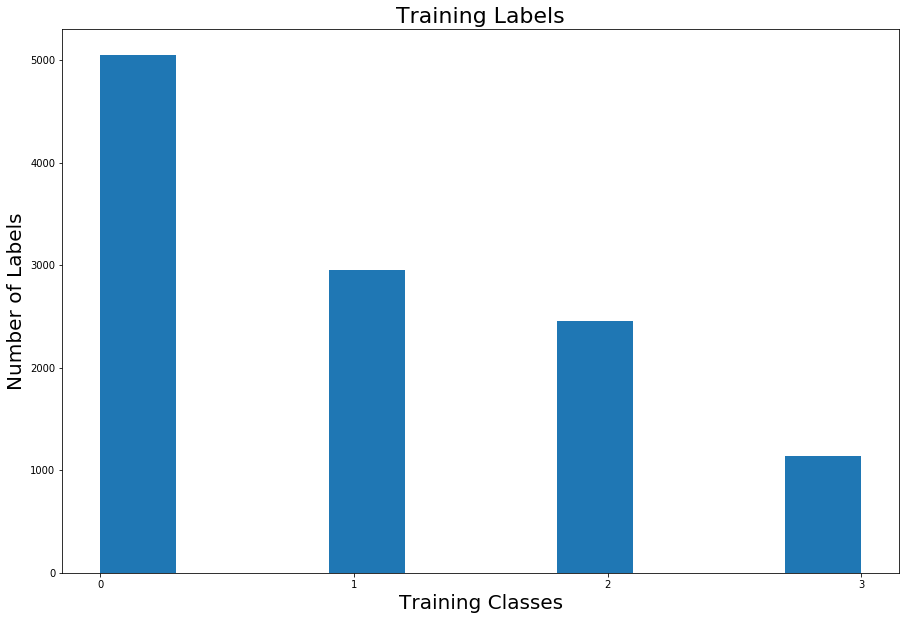

In [18]:
plt.figure(figsize=(15,10))
plt.hist(labels_train)
plt.title('Training Labels', fontsize=22)
plt.xlabel('Training Classes', fontsize=20)
plt.xticks([0, 1, 2, 3])
plt.ylabel('Number of Labels', fontsize=20)
plt.show()

In [46]:
x_train = torch.tensor(train_data).float().unsqueeze(1)
y_train = torch.tensor(labels_train).long()
x_test = torch.tensor(test_data).float().unsqueeze(1)
y_test = torch.tensor(validation_labels_np).long()

In [47]:
class LSTM(torch.nn.Module):
    def __init__(self, n_channels, n_features, n_hidden_d, n_classes, fft_samples,
                lstm_layers=1, dropout=0):
        super(LSTM, self).__init__()
        self.name = 'LSTM'
        if lstm_layers > 1:
            self.lstm_0 = torch.nn.LSTM(n_features, n_hidden_d, lstm_layers, dropout=dropout)
            #self.lstm_0 = nn.GRU(n_features, n_hidden_d, lstm_layers, dropout=dropout)
        else:
            self.lstm_0 = torch.nn.LSTM(n_features, n_hidden_d, lstm_layers)
        self.n_hidden_d = n_hidden_d
        self.fc_1 = nn.Linear(self.n_hidden_d,
                              n_classes)
        self.fft_samples = fft_samples
        
    def forward(self, x):
        x = x.float()
        signal_data = x
        lstm_out, (h,c) = self.lstm_0(signal_data)
        x = torch.tanh(lstm_out)
        x = self.fc_1(x.flatten(1))
        x = F.softmax(x, dim=1)
        return x


In [48]:
device = torch.device('cuda')
model_name = LSTM.__name__
n_channels = 1
n_features = sample_size
fft_samples = 1500
n_hidden_d = int(n_features / 5)
n_classes = 4
lstm_layers = 1
model = None
n_epochs = 10
model = NeuralNetClassifier(module=LSTM, 
                            criterion=nn.CrossEntropyLoss,
                            module__n_channels= n_channels,
                            module__n_features=n_features,
                            module__n_hidden_d = n_hidden_d,
                            module__n_classes = n_classes,
                            module__fft_samples = fft_samples,
                            module__lstm_layers = lstm_layers,
                            optimizer=optim.Adam, 
                            optimizer__lr=0.001,
                            max_epochs=n_epochs, 
                            batch_size=32,
                            iterator_train__shuffle=True,
                            device=device,
                            warm_start=True,
                           )


In [27]:
model.fit(x_train, y_train, epochs=2)

     11        0.7456       0.7467        0.9908  44.0009
     12        0.7454       0.7445        0.9923  44.0049


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LSTM(
    (lstm_0): LSTM(12000, 2400)
    (fc_1): Linear(in_features=2400, out_features=4, bias=True)
  ),
)

In [49]:
classes = ['N', 'A', 'O', '~']

In [50]:
def plot_confusion_matrix(y_pred, y, prefix_information='',
                          dataset_name='', save_results=False,
                          y_pred_is_predicted_classes=False):
    """
    PLotting confusion matrix of different datasets (train, test, and validation).
    :param y_pred:
    :param y:
    :param prefix_information:
    :param dataset_name:
    :param save_results:
    :param y_pred_is_predicted_classes:
    :return:
    """
    if 'Tensor' in str(type(y)):
        y = y.numpy()
    c_matrix = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    result_accuracy_string = "Accuracy of Net: {:.2f}".format(accuracy)
    print(result_accuracy_string)
    print("\nClassification report:")
    classfication_report_string = classification_report(y, y_pred)
    print(classfication_report_string)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    #ax.set_title(dataset_name + " Confusion matrix")
    ax.set_title(" Confusion matrix", fontsize=24)
    sns.heatmap(c_matrix, cmap='Blues', 
                annot=True, xticklabels=classes, 
                yticklabels=classes, fmt='g', cbar=False)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xlabel('predictions', fontsize=22)
    ax.set_ylabel('true labels', fontsize=22)
    plt.tick_params(labelsize=18)
    plt.tight_layout()
    # plt.show()
    return accuracy
    

In [51]:
model.initialize()
model_name = 'models/LSTM_model_acc_92'
model.load_params(f=model_name + '_file.pkl',
                  f_params=model_name + '.pkl', 
                  f_optimizer=model_name + '_opt.pkl', 
                  f_history=model_name + '_history.json')


Accuracy of Net: 0.92

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       150
           1       0.98      0.94      0.96        50
           2       0.94      0.83      0.88        70
           3       0.74      0.93      0.82        30

   micro avg       0.92      0.92      0.92       300
   macro avg       0.90      0.91      0.90       300
weighted avg       0.93      0.92      0.92       300



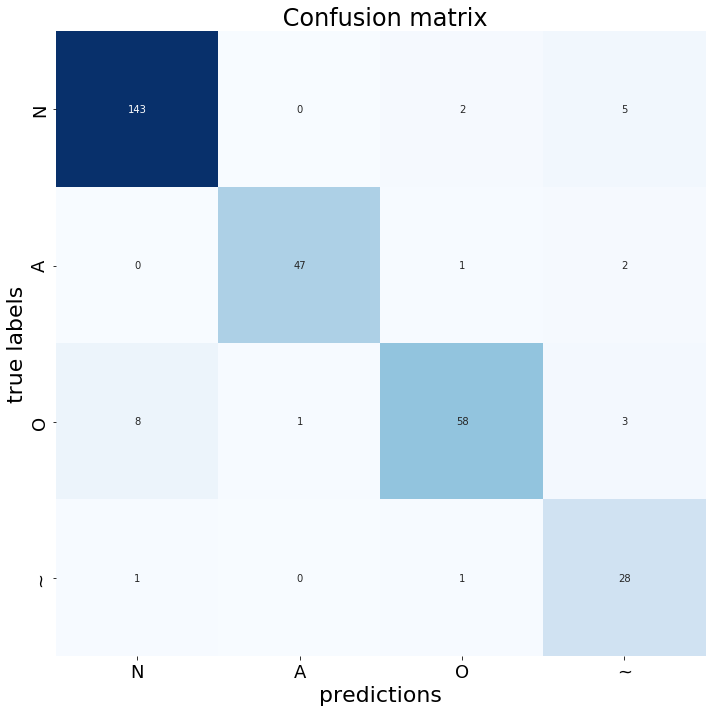

In [52]:
pred_test = model.predict(x_test)
accuracy = plot_confusion_matrix(pred_test, y_test, )

Accuracy of Net: 0.95

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5050
           1       0.99      1.00      0.99      2952
           2       0.91      0.85      0.88      2456
           3       0.99      0.99      0.99      1136

   micro avg       0.95      0.95      0.95     11594
   macro avg       0.96      0.95      0.95     11594
weighted avg       0.95      0.95      0.95     11594



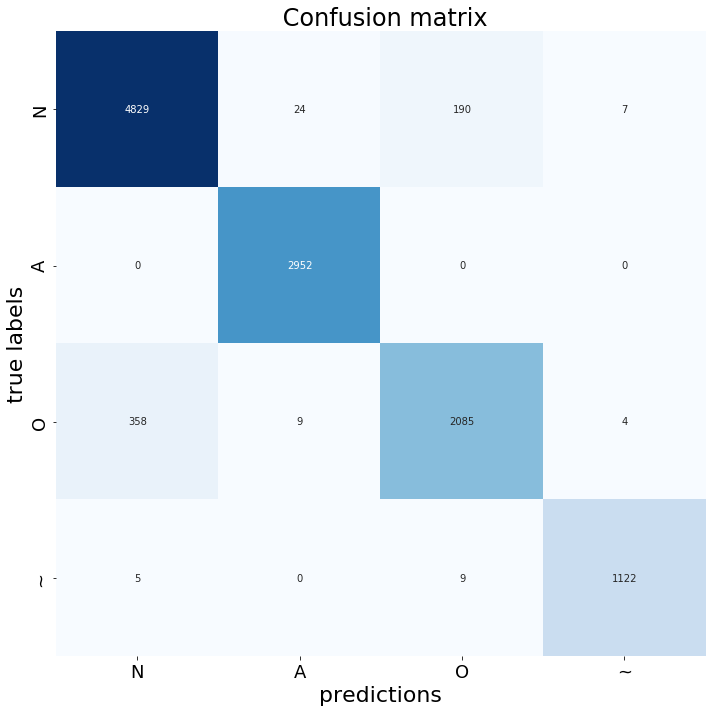

In [53]:
pred_train = model.predict(x_train)
accuracy = plot_confusion_matrix(pred_train, y_train, )

In [50]:
model_name = 'models/LSTM_model_acc_92'
model.save_params(f=model_name + '_file.pkl',
                  f_params=model_name + '.pkl', 
                  f_optimizer=model_name + '_opt.pkl', 
                  f_history=model_name + '_history.json')